 # Clustering SARS-COV-2 Mpro Fragment Hits with a Self-Organizing Map


### Source code & credit: Pat Walters
https://github.com/PatWalters/blog_posts

## Clustering Fragment Crystal Structures

In this notebook we'll use a few Python libraries to analyze a set of non-covalent  fragment crystal structures binding the Mpro active site reported in https://fragalysis.diamond.ac.uk/viewer/react/preview/target/Mpro <br> <br>Here's a brief outline of the workflow. 
- Download the x-ray structures from the PDB
- Align the structures to a reference structures
- Write the aligned protein structures to disk
- Extract the ligands and assign bond orders
- Write ligands to disk
- Cluster using a Self-Organizing MAP (SOM)

### 0. Install libraries
Install the necessary packages

In [ ]:
!pip install useful_rdkit_utils minisom prody seaborn

In [1]:
from rdkit import Chem
from rdkit.Chem import AllChem
from rdkit.Chem import PandasTools
import pandas as pd
from prody import *
from tqdm.auto import tqdm
from io import StringIO
from operator import itemgetter
from rdkit import RDLogger 
import numpy as np
from rdkit.Chem.rdMolTransforms import ComputeCentroid
from minisom import MiniSom 
import seaborn as sns
from glob import glob
import os
import useful_rdkit_utils as uru

### 1. Setup

Enable Pandas progress_apply

In [2]:
tqdm.pandas()

A function to extract a ligand from a complex, covert to an RDKit molecule, and assign bond orders. 

In [3]:
def prody_ligand_bond_order(protein, res_name, res_smiles):
    """
    Extract the ligand with the specified residue name from a Prody molecule and assign bond orders
    :param protein: Prody protein
    :param res_name: residue with the ligand
    :param res_smiles: SMILES for the ligand, used for bond order assignment
    :return: RDKit molecule with bond orders assigned
    """
    output = StringIO()
    sub_mol = protein.select(f"resname {res_name}")
    template = AllChem.MolFromSmiles(res_smiles)
    template = uru.get_largest_fragment(template)
    writePDBStream(output, sub_mol)
    pdb_string = output.getvalue()
    rd_mol = AllChem.MolFromPDBBlock(pdb_string)
    RDLogger.DisableLog('rdApp.warning')  
    new_mol = AllChem.AssignBondOrdersFromTemplate(template, rd_mol)
    RDLogger.EnableLog('rdApp.warning')  
    return new_mol

## 2. Reading and Processing Data From the PDB
### 2.1 Read the Input Data
Read the spreadsheet with info on the fragments. The spreadhseet maps the PDB code and ligand residue ID to the ligand SMILES.  We can use this information in step 2.2 below to assign bond orders to the ligand. 

In [4]:
df = pd.read_excel("./data/Mpro_frag_pdbs.xlsx")

In [5]:
df

,PDB,SMILES,Ligand_RESID
0,5R7Y,CS(=O)(=O)NCCc1ccccc1,JFM 1001
1,5R7Z,CC(=O)NCCc1c[nH]c(c12)ccc(F)c2,T5Y 404
2,5R80,COC(=O)c1ccc(cc1)S(=O)(=O)N,RZG 404
3,5R81,C1CCN(C)c(c12)cc(cc2)S(=O)(=O)N,RZJ 1001
4,5R82,N#Cc1ccc(nc1)NCC,RZS 1001
5,5R83,c1ncccc1NC(=O)Nc2ccccc2,K0G 404
6,5R84,C1CCCCC1CC(=O)Nc2cccnc2,GWS 1001
7,5RE4,CC(=O)Nc(c1C)cncc1,SZY 404
8,5RE9,C1CN(C)CCN1C(=O)COc(cc2)ccc2C,LPZ 404
9,5REB,OC1CCN(CC1)Cc2ccsc2,T0Y 404


### 2.2 Extract Ligands and Assign Bond Orders
1. Align each protein to the reference
2. Extract the ligand and assign bond orders
3. Build up a list of ligands

Run ProDy <br> 
ProDy is a free and open-source Python package for protein structural dynamics analysis.

In [6]:
#Make Prody less chatty
prody.confProDy(verbosity='critical')

Set up a reference protein to align the other proteins to

In [7]:
ref_prot = prody.parsePDB('7K0F')
ref_prot = ref_prot.select("chain A")

In [8]:
rd_ligand_list = []
for p,smi, res in tqdm(df[['PDB','SMILES','Ligand_RESID']].values):
    prot = prody.parsePDB(p)
    # break if we can't get the PDB
    if prot is None:
        continue
    # loop over chains and find the first one with the specified ligand
    hv = prot.getHierView()
    for chain in hv:
        if chain.select(f"resname {res}"):
            # align to the reference
            atommaps = prody.alignChains(chain, ref_prot)
            top_atommap = atommaps[0]
            torf_mapped = top_atommap.getFlags("mapped")
            prody.superpose(top_atommap, ref_prot, torf_mapped)
            # save the aligned pdb
            prody.writePDB(f"{p}_aligned.pdb",chain)
            
            # get the ligand and assign bond orders
            rd_lig_mol = prody_ligand_bond_order(chain,res,smi)
            rd_lig_mol.SetProp("Name",p)
            rd_lig_mol.SetProp("_Name",p)
            rd_ligand_list.append(rd_lig_mol)
            break

  0%|          | 0/34 [00:00<?, ?it/s]

Let's see how many ligands we ended up with

In [9]:
len(rd_ligand_list)

33

Save the ligands to a file

In [10]:
writer = Chem.SDWriter("ligs_complete.sdf")
for mol in rd_ligand_list:
    writer.write(mol)
writer.close()

### 2.3 Handle Multiple Ligands
Some of the pdb files have multiple copies of the same ligand bound in different pockets.  Separate these into individual ligands 

In [11]:
frag_mol_list = []
for idx,mol in enumerate(rd_ligand_list,1):
    name = mol.GetProp("Name")
    frag_list = Chem.GetMolFrags(mol,asMols=True)
    for frag_idx,frag in enumerate(frag_list):
        frag.SetProp("Name",name)
        frag.SetProp("Sequence",str(frag_idx))
        frag.SetProp("_Name",name)
        frag_mol_list.append(frag)
print(f"Read {idx} molecules containing {len(frag_mol_list)} fragments")

Read 33 molecules containing 33 fragments


Write the separated ligands to a file

In [12]:
writer = Chem.SDWriter("ligs_separated.sdf")
for mol in frag_mol_list:
    writer.write(mol)
writer.close()

## 3. Calculate the Center of Each Ligand
Create a dataframe with the ligands

In [13]:
lig_df = pd.DataFrame({'ROMol' : frag_mol_list, 
                       'Name': [x.GetProp("Name") for x in frag_mol_list],
                       'Sequence': [x.GetProp("Sequence") for x in frag_mol_list]
                      })

Calculate the geometric center for each ligand

In [14]:
lig_df['center'] = lig_df.ROMol.progress_apply(uru.get_center)

  0%|          | 0/33 [00:00<?, ?it/s]

Create a numpy array containing the ligand centers

In [15]:
X = np.stack(lig_df.center)

## 4. Use a Self-Organizing Map (SOM) to Cluster the Ligands

Initialize the SOM

In [16]:
som = MiniSom(5,5,3, random_seed=1)
som.train(X,1000)
cell = [som.winner(i) for i in X]

Create column in the dataframe to hold the cell ids

In [17]:
lig_df['cell'] = cell

In [18]:
lig_df

,ROMol,Name,Sequence,center,cell
0,<rdkit.Chem.rdchem.Mol object at 0x7fae049f4350>,5R7Y,0,"[13.249461538461539, 22.272230769230774, 30.09...","(4, 3)"
1,<rdkit.Chem.rdchem.Mol object at 0x7fae049f4820>,5R80,0,"[13.964214285714288, 25.18, 26.190714285714286]","(4, 1)"
2,<rdkit.Chem.rdchem.Mol object at 0x7fae049f4200>,5R81,0,"[13.6084, 24.955733333333335, 26.351799999999994]","(4, 1)"
3,<rdkit.Chem.rdchem.Mol object at 0x7fae049f43c0>,5R82,0,"[13.869000000000002, 23.278363636363636, 28.25...","(4, 2)"
4,<rdkit.Chem.rdchem.Mol object at 0x7fae049f4430>,5R83,0,"[10.689875, 22.155312500000004, 26.73431249999...","(0, 1)"
5,<rdkit.Chem.rdchem.Mol object at 0x7fae049f49e0>,5R84,0,"[10.98325, 21.9586875, 27.040125000000003]","(0, 0)"
6,<rdkit.Chem.rdchem.Mol object at 0x7fae049f4a50>,5RE4,0,"[9.023272727272728, 21.75272727272727, 26.5504...","(0, 3)"
7,<rdkit.Chem.rdchem.Mol object at 0x7fae049f4ac0>,5RE9,0,"[12.346777777777781, 25.580666666666662, 31.04...","(3, 3)"
8,<rdkit.Chem.rdchem.Mol object at 0x7fae049f4b30>,5REB,0,"[13.781538461538462, 22.16646153846154, 30.418...","(4, 3)"
9,<rdkit.Chem.rdchem.Mol object at 0x7fae049f4ba0>,5REH,0,"[5.17038888888889, 24.85977777777778, 27.97638...","(0, 4)"


Create a dataframe to hold the occupied SOM cells

In [19]:
cell_df = lig_df.cell.value_counts().to_frame().reset_index()
cell_df.columns = ["Cell","Count"]

Plot the SOM, the point size is proportional to the number of ligands in a cell.  The numbers adjacent to the points are the cluster ids.  Adjacent cells represent clusters that are close 3D in space (adjacent pockets) on the protein.  

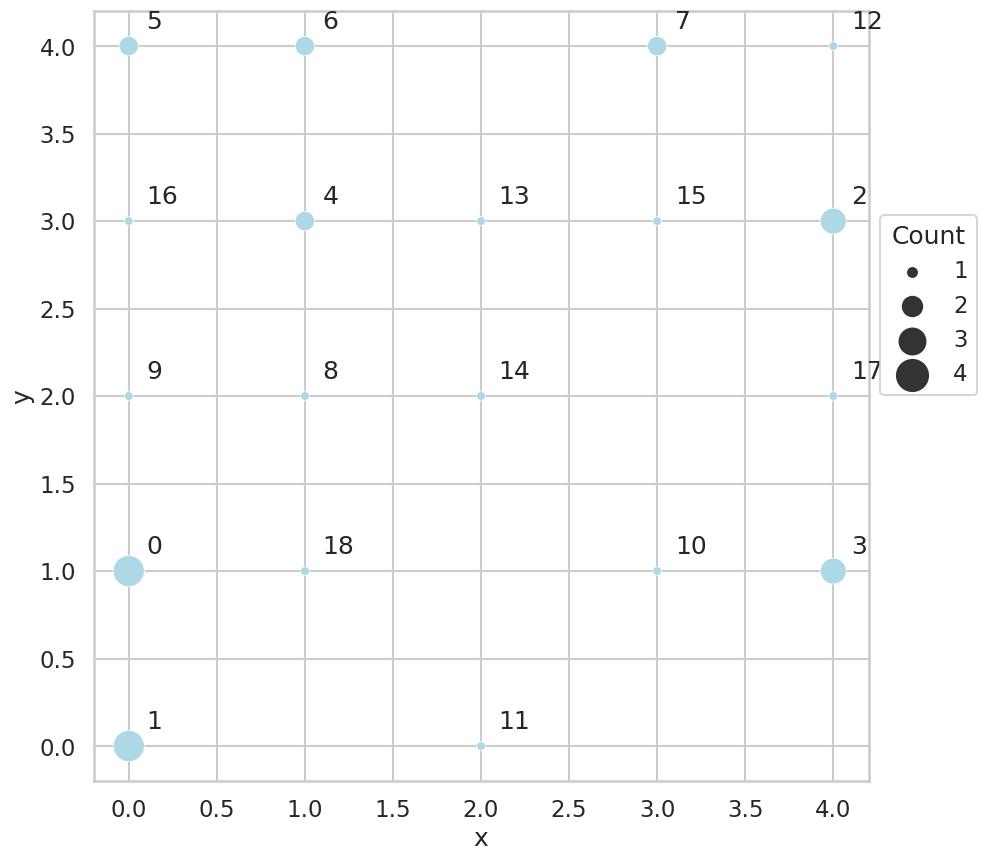

In [20]:
sns.set(rc={'figure.figsize': (10, 10)})
sns.set_style('whitegrid')
sns.set_context('talk')
cell_df['x'] = [x[0] for x in cell_df.Cell]
cell_df['y'] = [x[1] for x in cell_df.Cell]
ax = sns.scatterplot(x="x",y='y',size="Count",data=cell_df,sizes=(40,500),color="lightblue")
ax.legend(title="Count",loc='upper left', bbox_to_anchor=(1.00, 0.75), ncol=1)
cell_df.sort_values('Count',ascending=False)
cell_df['ix'] = range(0,len(cell_df))
for x,y,ix in cell_df[['x','y','ix']].values:
    ax.text(x+0.1,y+0.1,ix)    

In [ ]:
# delete any files named som_cluster*.sdf
for filename in glob("som_cluster*.sdf"):
    os.unlink(filename)

# write each cluster as an SDF
for i,x in enumerate(lig_df.cell.value_counts().index):
    cluster_df = lig_df.query("cell == @x")
    filename = f"som_cluster_{i:03d}.sdf"
    print(filename, x, cluster_df.shape[0])
    PandasTools.WriteSDF(cluster_df,filename,properties=["Name","Sequence"])

Write each cluster to an SD file.  To look at the clusters with PyMol, you can do 
<pre>
pymol 5R7Y_aligned.pdb som_cluster*.sdf
</pre>
Then, in PyMol, execute these commands
<pre>
zoom all
set all_states,on

MIT License

Copyright (c) 2021 Patrick Walters

Permission is hereby granted, free of charge, to any person obtaining a copy
of this software and associated documentation files (the "Software"), to deal
in the Software without restriction, including without limitation the rights
to use, copy, modify, merge, publish, distribute, sublicense, and/or sell
copies of the Software, and to permit persons to whom the Software is
furnished to do so, subject to the following conditions:

The above copyright notice and this permission notice shall be included in all
copies or substantial portions of the Software.